In [ ]:
!rm -rf /gpfs/global_fs01/sym_shared/YPProdSpark/user/s0d5-a7406a340d8065-5626aa220b46/notebook/work/metastore_db/*.lck

In [9]:
game_df = sqlContext.read.format('jdbc').options(url='jdbc:db2://bluemix05.bluforcloud.com:50000/BLUDB', dbtable='DASH019163.GAME', user='dash019163', password='p9lF04HeD7ZQ').load()

In [10]:
game_df.registerTempTable("game")

In [11]:
query = """
CREATE TEMPORARY TABLE player
USING org.apache.spark.sql.jdbc
OPTIONS (
   url 'jdbc:db2://bluemix05.bluforcloud.com:50000/BLUDB', 
  dbtable 'DASH019163.PLAYER', 
  user 'dash019163', 
  password 'p9lF04HeD7ZQ'
)
"""
player = sqlContext.sql(query)

In [12]:
query = """
select
 COLLEGE,
 count(*) as COUNT
from
 player
where
 COLLEGE is not null
group by
 COLLEGE
order by count(*) desc
limit 20
"""
player_pd = sqlContext.sql(query).toPandas()

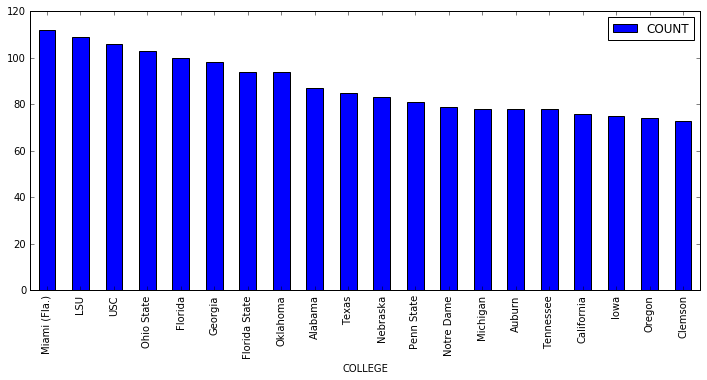

In [13]:
%matplotlib inline 
import matplotlib.pyplot as plt, numpy as np

player_pd.plot(kind='bar', x='COLLEGE', figsize=(12, 5))

In [14]:
query = """

SELECT GSIS_ID
       , GAMEKEY
       , START_TIME
       , WEEK
       , DAY_OF_WEEK
       , SEASON_YEAR
       , SEASON_TYPE
       , FINISHED
	   , HOME_TEAM as LOCATION
	   , 1 as HOME_GAME
       , HOME_TEAM as TEAM
       , HOME_SCORE as SCORE
       , HOME_SCORE_Q1 as SCORE_Q1
       , HOME_SCORE_Q2 as SCORE_Q2
       , HOME_SCORE_Q3 as SCORE_Q3
       , HOME_SCORE_Q4 as SCORE_Q4
       , HOME_SCORE_Q5 as SCORE_Q5
       , HOME_TURNOVERS as TURNOVERS
	   , AWAY_TEAM as OPPONENT_TEAM
       , AWAY_SCORE as OPPONENT_SCORE
       , AWAY_SCORE_Q1 as OPPONENT_SCORE_Q1
       , AWAY_SCORE_Q2 as OPPONENT_SCORE_Q2
       , AWAY_SCORE_Q3 as OPPONENT_SCORE_Q3
       , AWAY_SCORE_Q4 as OPPONENT_SCORE_Q4
       , AWAY_SCORE_Q5 as OPPONENT_SCORE_Q5
       , AWAY_TURNOVERS as OPPONENT_TURNOVERS
	   ,CASE 
	   		WHEN HOME_SCORE > AWAY_SCORE then 1
			WHEN HOME_SCORE < AWAY_SCORE then 0
		END as  WON
		,CASE 
	   		WHEN HOME_SCORE = AWAY_SCORE then 1
			WHEN HOME_SCORE != AWAY_SCORE then 0
		END as  TIE
  FROM game
  UNION ALL
  SELECT GSIS_ID
       , GAMEKEY
       , START_TIME
       , WEEK
       , DAY_OF_WEEK
       , SEASON_YEAR
       , SEASON_TYPE
       , FINISHED
       , HOME_TEAM as LOCATION
	   , 0 as HOME_GAME
       , AWAY_TEAM as TEAM
       , AWAY_SCORE as SCORE
       , AWAY_SCORE_Q1 as SCORE_Q1
       , AWAY_SCORE_Q2 as SCORE_Q2
       , AWAY_SCORE_Q3 as SCORE_Q3
       , AWAY_SCORE_Q4 as SCORE_Q4
       , AWAY_SCORE_Q5 as SCORE_Q5
       , AWAY_TURNOVERS as TURNOVERS
	   , HOME_TEAM as OPPONENT_TEAM
       , HOME_SCORE as OPPONENT_SCORE
       , HOME_SCORE_Q1 as OPPONENT_SCORE_Q1
       , HOME_SCORE_Q2 as OPPONENT_SCORE_Q2
       , HOME_SCORE_Q3 as OPPONENT_SCORE_Q3
       , HOME_SCORE_Q4 as OPPONENT_SCORE_Q4
       , HOME_SCORE_Q5 as OPPONENT_SCORE_Q5
       , HOME_TURNOVERS as OPPONENT_TURNOVERS
	   ,CASE 
	   		WHEN AWAY_SCORE > HOME_SCORE then 1
			WHEN AWAY_SCORE < HOME_SCORE then 0
		END as  WON
		,CASE 
	   		WHEN HOME_SCORE = AWAY_SCORE then 1
			WHEN HOME_SCORE != AWAY_SCORE then 0
		END as  TIE
  FROM game
"""

In [15]:
games_norm_df = sqlContext.sql(query)
games_norm_df.registerTempTable("game_normalized")

In [16]:
games_norm_df.printSchema()

root
 |-- GSIS_ID: integer (nullable = false)
 |-- GAMEKEY: integer (nullable = false)
 |-- START_TIME: timestamp (nullable = false)
 |-- WEEK: integer (nullable = false)
 |-- DAY_OF_WEEK: string (nullable = false)
 |-- SEASON_YEAR: integer (nullable = false)
 |-- SEASON_TYPE: string (nullable = false)
 |-- FINISHED: string (nullable = false)
 |-- LOCATION: string (nullable = false)
 |-- HOME_GAME: integer (nullable = false)
 |-- TEAM: string (nullable = false)
 |-- SCORE: integer (nullable = false)
 |-- SCORE_Q1: integer (nullable = false)
 |-- SCORE_Q2: integer (nullable = false)
 |-- SCORE_Q3: integer (nullable = false)
 |-- SCORE_Q4: integer (nullable = false)
 |-- SCORE_Q5: integer (nullable = false)
 |-- TURNOVERS: integer (nullable = false)
 |-- OPPONENT_TEAM: string (nullable = false)
 |-- OPPONENT_SCORE: integer (nullable = false)
 |-- OPPONENT_SCORE_Q1: integer (nullable = false)
 |-- OPPONENT_SCORE_Q2: integer (nullable = false)
 |-- OPPONENT_SCORE_Q3: integer (nullable = fa

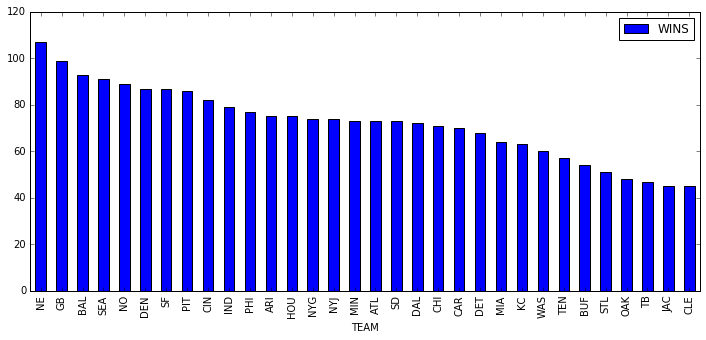

In [17]:
query = """
select
    sum(WON) as WINS,
    TEAM
FROM
    game_normalized
GROUP BY
    TEAM
ORDER BY WINS desc
"""
pd = sqlContext.sql(query).toPandas()
pd.plot(kind='bar', x='TEAM', figsize=(12, 5))

In [18]:
team_df = sqlContext.read.format('jdbc').options(url='jdbc:db2://bluemix05.bluforcloud.com:50000/BLUDB', dbtable='DASH019163.TEAM', user='dash019163', password='p9lF04HeD7ZQ').load()
team_df.registerTempTable("team")

In [19]:
import urllib
from bs4 import BeautifulSoup
import re


url = "https://en.wikipedia.org/wiki/National_Football_League"

html = urllib.urlopen(url)
bsObj = BeautifulSoup(html, "html.parser")

table = bsObj.find("table", {"class": "navbox plainrowheaders wikitable"})
rows = table.findAll("tr")


def clean_string(cstring):

    st = cstring.replace("*", "")
    st = re.sub(r'[^\x00-\x7F]+',' ', st)

    if st.__contains__("["):
        return st[0:st.index("[")]
    else:
        return st


stadiums_l = []

for row in rows:
    r = []
    for cell in row.findAll(['td', 'th']):
        r.append(cell.get_text())

        if len(r) == 7 and r[0] not in ["North", "South", "East", "West", "Division[52]"]:
            team = clean_string(r[0])
            location = clean_string(r[1])
            stadium = clean_string(r[2])
            lat = r[4].split(" ")[6].replace(";", "")
            long = r[4].split(" ")[7][0:7]

            stadiums_l.append([team, location, stadium, lat, long])

        if len(r) == 8 and r[1] not in ["Club[52]"]:
            team = clean_string(r[1])
            location = r[2]
            stadium = r[3]
            lat = r[5].split(" ")[6].replace(";", "")
            long = r[5].split(" ")[7][0:7]
            stadiums_l.append([team, location, stadium, lat, long])

print stadiums_l[0]
print stadiums_l[1]

[u'Buffalo Bills', u'Orchard Park, NY', u'Ralph Wilson Stadium', u'42.774', u'-78.787']
[u'Miami Dolphins', u'Miami Gardens, FL', u'New Miami Stadium', u'25.958', u'-80.239']


In [20]:
from pyspark.sql import Row

stadiums_rdd = sc.parallelize(stadiums_l)
stadiums_df = stadiums_rdd.map(lambda x: Row(team=x[0], stadium_city=x[1], stadium_name=x[2], latitude=x[3], longitude=x[4])).toDF()
stadiums_df.registerTempTable("stadiums")

for s in stadiums_df.take(2):
    print s

Row(latitude=u'42.774', longitude=u'-78.787', stadium_city=u'Orchard Park, NY', stadium_name=u'Ralph Wilson Stadium', team=u'Buffalo Bills')
Row(latitude=u'25.958', longitude=u'-80.239', stadium_city=u'Miami Gardens, FL', stadium_name=u'New Miami Stadium', team=u'Miami Dolphins')


In [21]:
sqlContext.sql("select * from stadiums").toPandas()

,latitude,longitude,stadium_city,stadium_name,team
0,42.774,-78.787,"Orchard Park, NY",Ralph Wilson Stadium,Buffalo Bills
1,25.958,-80.239,"Miami Gardens, FL",New Miami Stadium,Miami Dolphins
2,42.091,-71.264,"Foxborough, MA",Gillette Stadium,New England Patriots
3,40.814,-74.074,"East Rutherford, NJ",MetLife Stadium,New York Jets
4,39.278,-76.623,"Baltimore, MD",M&T Bank Stadium,Baltimore Ravens
5,39.095,-84.516,"Cincinnati, OH",Paul Brown Stadium,Cincinnati Bengals
6,41.506,-81.699,"Cleveland, OH",FirstEnergy Stadium,Cleveland Browns
7,40.447,-80.016,"Pittsburgh, PA",Heinz Field,Pittsburgh Steelers
8,29.685,-95.411,"Houston, TX",NRG Stadium,Houston Texans
9,39.760,-86.164,"Indianapolis, IN",Lucas Oil Stadium,Indianapolis Colts


In [22]:
def match_strings_fuzzy(str1, str2):
    return str1.lower() in str2.lower()

sqlContext.registerFunction("match_strings_fuzzy", match_strings_fuzzy)

In [23]:
query = """
select
    lower(CITY + NAME),
    TEAM_ID,
    CITY,
    NAME,
    stadium_city,
    stadium_name,
    team,
    latitude,
    longitude,
    match_strings_fuzzy(NAME, team)
from
    team, stadiums
where
    match_strings_fuzzy(NAME, team) = 'true'
"""

team_locations = sqlContext.sql(query)
team_locations.registerTempTable("team_locations")
team_locations.toPandas()

,_c0,TEAM_ID,CITY,NAME,stadium_city,stadium_name,team,latitude,longitude,_c9
0,None,BAL,Baltimore,Ravens,"Baltimore, MD",M&T Bank Stadium,Baltimore Ravens,39.278,-76.623,true
1,None,BUF,Buffalo,Bills,"Orchard Park, NY",Ralph Wilson Stadium,Buffalo Bills,42.774,-78.787,true
2,None,CIN,Cincinnati,Bengals,"Cincinnati, OH",Paul Brown Stadium,Cincinnati Bengals,39.095,-84.516,true
3,None,CLE,Cleveland,Browns,"Cleveland, OH",FirstEnergy Stadium,Cleveland Browns,41.506,-81.699,true
4,None,DEN,Denver,Broncos,"Denver, CO",Sports Authority Field at Mile High,Denver Broncos,39.744,-105.02,true
5,None,HOU,Houston,Texans,"Houston, TX",NRG Stadium,Houston Texans,29.685,-95.411,true
6,None,IND,Indianapolis,Colts,"Indianapolis, IN",Lucas Oil Stadium,Indianapolis Colts,39.760,-86.164,true
7,None,JAC,Jacksonville,Jaguars,"Jacksonville, FL",EverBank Field,Jacksonville Jaguars,30.324,-81.638,true
8,None,KC,Kansas City,Chiefs,"Kansas City, MO",Arrowhead Stadium,Kansas City Chiefs,39.049,-94.484,true
9,None,MIA,Miami,Dolphins,"Miami Gardens, FL",New Miami Stadium,Miami Dolphins,25.958,-80.239,true


In [24]:
query = """
select
    DISTINCT
    GSIS_ID,
    START_TIME,
    team_locations.stadium_city as stadium_city,
    latitude,
    longitude,
    game_normalized.LOCATION
from
    game_normalized 
inner join team_locations on
     game_normalized.LOCATION = team_locations.TEAM_ID
limit 10
"""
sqlContext.sql(query).toPandas()

,GSIS_ID,START_TIME,stadium_city,latitude,longitude,LOCATION
0,2015082955,2015-08-29 16:00:00,"Tampa, FL",27.976,-82.503,TB
1,2009082750,2009-08-27 17:00:00,"Tampa, FL",27.976,-82.503,TB
2,2009091308,2009-09-13 10:00:00,"Tampa, FL",27.976,-82.503,TB
3,2009110806,2009-11-08 10:00:00,"Tampa, FL",27.976,-82.503,TB
4,2010082854,2010-08-28 16:30:00,"Tampa, FL",27.976,-82.503,TB
5,2010101708,2010-10-17 10:00:00,"Tampa, FL",27.976,-82.503,TB
6,2009090450,2009-09-04 16:00:00,"Tampa, FL",27.976,-82.503,TB
7,2011091106,2011-09-11 10:00:00,"Tampa, FL",27.976,-82.503,TB
8,2011121700,2011-12-17 17:20:00,"Tampa, FL",27.976,-82.503,TB
9,2012082453,2012-08-24 16:30:00,"Tampa, FL",27.976,-82.503,TB


In [25]:
query = """
select
    DISTINCT
    GSIS_ID,
    START_TIME,
    team_locations.stadium_city as stadium_city,
    latitude,
    longitude,
    game_normalized.LOCATION
from
    game_normalized 
inner join team_locations on
     game_normalized.LOCATION = team_locations.TEAM_ID
"""
distinct_games_df = sqlContext.sql(query)
distinct_games_df.registerTempTable("distinct_games")
print distinct_games_df.count()

2316


In [26]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

#function to take the left 8 characters of the Game ID (represents the YEARMONTHDAY)
def parse_datekey(datestr):
    if len(str(datestr)) >= 8:
        return str(datestr)[0:8]
    else:
        return ""

#Register the function for Spark
parse_datekey_udf = udf(parse_datekey, StringType())
                            
#create the new dataframe with the datekey column
distinct_games_df_withdate = distinct_games_df.withColumn("datekey", parse_datekey_udf(distinct_games_df["GSIS_ID"]))

distinct_games_df_withdate.registerTempTable("distinct_games_df_withdate")

#sample of first 5 rows
for x in distinct_games_df_withdate.take(5):
    print x


Row(GSIS_ID=2013120807, START_TIME=datetime.datetime(2013, 12, 8, 10, 0), stadium_city=u'Tampa, FL', latitude=u'27.976', longitude=u'-82.503', LOCATION=u'TB', datekey=u'20131208')
Row(GSIS_ID=2014082808, START_TIME=datetime.datetime(2014, 8, 28, 16, 30), stadium_city=u'Tampa, FL', latitude=u'27.976', longitude=u'-82.503', LOCATION=u'TB', datekey=u'20140828')
Row(GSIS_ID=2014090711, START_TIME=datetime.datetime(2014, 9, 7, 13, 25), stadium_city=u'Tampa, FL', latitude=u'27.976', longitude=u'-82.503', LOCATION=u'TB', datekey=u'20140907')
Row(GSIS_ID=2014091409, START_TIME=datetime.datetime(2014, 9, 14, 13, 5), stadium_city=u'Tampa, FL', latitude=u'27.976', longitude=u'-82.503', LOCATION=u'TB', datekey=u'20140914')
Row(GSIS_ID=2014101207, START_TIME=datetime.datetime(2014, 10, 12, 10, 0), stadium_city=u'Tampa, FL', latitude=u'27.976', longitude=u'-82.503', LOCATION=u'TB', datekey=u'20141012')


In [27]:
import os
wapi_key = open("./wapi_key.txt", "r").read().replace("\n", "")


In [28]:
import datetime, time, json, requests

def get_weather(date_str, lat, long):
    #Build the URI to get the JSON blob
    uri = "https://api.weather.com/v1/geocode/{lat}/{long}/observations/historical.json?units=e&startDate={date}&endDate={date}&apiKey={key}".format( \
        lat=lat, long=long, date=date_str, key=wapi_key)

    #get JSON blob and create JSON object
    r = requests.get(uri)
    weather_json = json.loads(r.text)
    r_dict = {}
    
    return weather_json

sqlContext.registerFunction("get_weather", get_weather)

In [29]:
def get_weather_uri(date_str, lat, long):
    #Build the URI to get the JSON blob
    uri = "https://api.weather.com/v1/geocode/{lat}/{long}/observations/historical.json?units=e&startDate={date}&endDate={date}&apiKey={key}".format( \
        lat=lat, long=long, date=date_str, key=wapi_key)
    return uri

sqlContext.registerFunction("get_weather_uri", get_weather_uri)

In [35]:
#distinct_games_weather_df = distinct_games_df_withdate.filter(distinct_games_df_withdate.datekey == 20141221).map(lambda x: Row(**dict(x.asDict(), weather=get_weather(x.datekey, x.latitude, x.longitude)))).toDF()
distinct_games_weather_df = distinct_games_df_withdate.map(lambda x: Row(**dict(x.asDict(), weather=get_weather(x.datekey, x.latitude, x.longitude)))).toDF()
distinct_games_weather_df.registerTempTable("distinct_games_weather")
distinct_games_weather_df.printSchema()

root
 |-- GSIS_ID: long (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- START_TIME: timestamp (nullable = true)
 |-- datekey: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stadium_city: string (nullable = true)
 |-- weather: map (nullable = true)
 |    |-- key: string
 |    |-- value: array (valueContainsNull = true)
 |    |    |-- element: map (containsNull = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: long (valueContainsNull = true)



In [36]:
distinct_games_weather_df.show(5)

+----------+--------+--------------------+--------+--------+---------+------------+--------------------+
|   GSIS_ID|LOCATION|          START_TIME| datekey|latitude|longitude|stadium_city|             weather|
+----------+--------+--------------------+--------+--------+---------+------------+--------------------+
|2015082955|      TB|2015-08-29 16:00:...|20150829|  27.976|  -82.503|   Tampa, FL|Map(metadata -> n...|
|2009082750|      TB|2009-08-27 17:00:...|20090827|  27.976|  -82.503|   Tampa, FL|Map(metadata -> n...|
|2009091308|      TB|2009-09-13 10:00:...|20090913|  27.976|  -82.503|   Tampa, FL|Map(metadata -> n...|
|2009110806|      TB|2009-11-08 10:00:...|20091108|  27.976|  -82.503|   Tampa, FL|Map(metadata -> n...|
|2010082854|      TB|2010-08-28 16:30:...|20100828|  27.976|  -82.503|   Tampa, FL|Map(metadata -> n...|
+----------+--------+--------------------+--------+--------+---------+------------+--------------------+
only showing top 5 rows



In [37]:
distinct_games_weather_df.count()

2316

In [39]:
!rm -rf ./weather_p/
!rm -rf ./games_norm_df_p/

In [40]:
distinct_games_weather_df.write.parquet("./weather_p/")
games_norm_df.write.parquet("./games_norm_df_p/")